In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import time
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import model_from_yaml
os.environ["CUDA_VISIBLE_DEVICES"] = "0"



Using TensorFlow backend.


In [2]:
### Helper-function for joining a directory and list of filenames.
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 1)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for printing confusion matrix
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    np.savetxt('FineTune_Confusion_matrix.txt', cm)
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:3])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:3],
                cls_pred=cls_pred[0:3])

def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    fig=plt.figure()
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()
    fig.savefig('FineTune_errors.png')
    fig.savefig('FineTune_errors.eps')

## Example Predictions: 
# We need a helper-function for loading and resizing an image 
# so it can be input to the VGG16 model,
# as well as doing the actual prediction and showing the result.
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

## Helper-function for printing whether a layer in the VGG16 model should be trained.
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [3]:
train_dir = '../Data/UW_old_data/Training_frames_divided_roi/train/'
test_dir = '../Data/UW_old_data/Training_frames_divided_roi/valid/'
print('train_dir:',train_dir)


train_dir: ../Data/UW_old_data/Training_frames_divided_roi/train/


In [4]:
## Pre-Trained Model: VGG16
model = VGG16(include_top=True, weights='imagenet')
input_shape = model.layers[0].output_shape[1:3]
print('input_shape:',input_shape)

# rotation_range=180,zoom_range=[0.9, 1.5],
datagen_train = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      horizontal_flip=False,
      vertical_flip=False,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 20
# We can save the randomly transformed images during training, 
# so as to inspect whether they have been overly distorted,
# so we have to adjust the parameters for the data-generator above.
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

print(save_to_dir)
print('training set:')
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)


print('test set:')
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_test = generator_test.n / batch_size
print('steps_test:', steps_test)

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)
print(image_paths_train[0:9])

cls_train = generator_train.classes
cls_test = generator_test.classes

class_names = list(generator_train.class_indices.keys())

num_classes = generator_train.num_classes
print('num_classes:', num_classes)

# # Load the first images from the train-set.
# images = load_images(image_paths=image_paths_train[0:9])

# # Get the true classes for those images.
# cls_true = cls_train[0:9]

# # Plot the images and labels using our helper-function above.
# plot_images(images=images, cls_true=cls_true, smooth=True)

# Compute class weights
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

print('class_weight:', class_weight)
print('class_names:\n',class_names)

print('Model summary:')
print(model.summary())



input_shape: (224, 224)
None
training set:
Found 6697 images belonging to 11 classes.
test set:
Found 1481 images belonging to 11 classes.
steps_test: 74.05
['../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\100_none_bend_none_none_1.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\101_none_bend_none_none_1.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\102_none_bend_none_none_1.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\103_none_bend_none_none_1.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\105_none_bend_none_none_7.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\106_none_bend_none_none_7.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\107_none_bend_none_none_7.jpg', '../Data/UW_old_data/Training_frames_divided_roi/train/none_bend_none_none\\108_none_b

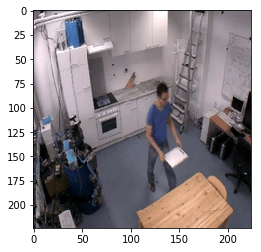

24.01% : refrigerator
10.39% : shower_curtain
 5.36% : toilet_seat
 3.96% : photocopier
 3.59% : lab_coat


In [5]:
## Running an example
predict(image_path='images/setting-a-table_walk_hold-both-hand_low-risk_314.jpg')


In [6]:
transfer_layer = model.get_layer('block5_pool')
print(transfer_layer.output)


conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

# Define the trainable layers
conv_model.trainable = True
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name) #'block4' in layer.name
    
    # Set the layer's bool.
    layer.trainable = trainable
print_layer_trainable()

# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(4096, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

optimizer_fine = Adam(lr=1e-7)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']




new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

print('Model summary:')
print(new_model.summary())


plot_model(new_model, to_file='VGG_model.png', show_shapes=True)

Tensor("block5_pool/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)         

In [14]:
epochs = 200
steps_per_epoch = 300

t = time.time()

history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

elapsed = time.time() - t
print('Time elapsed: ', elapsed)



Epoch 1/200
300/300 [==============================] - 67s 224ms/step - loss: 0.4701 - categorical_accuracy: 0.8189 - val_loss: 0.5776 - val_categorical_accuracy: 0.7718
Epoch 2/200
300/300 [==============================] - 80s 268ms/step - loss: 0.4524 - categorical_accuracy: 0.8344 - val_loss: 0.5825 - val_categorical_accuracy: 0.7691
Epoch 3/200
300/300 [==============================] - 62s 206ms/step - loss: 0.4713 - categorical_accuracy: 0.8201 - val_loss: 0.5764 - val_categorical_accuracy: 0.7765
Epoch 4/200
300/300 [==============================] - 49s 164ms/step - loss: 0.4617 - categorical_accuracy: 0.8241 - val_loss: 0.5771 - val_categorical_accuracy: 0.7698
Epoch 5/200
300/300 [==============================] - 50s 166ms/step - loss: 0.4542 - categorical_accuracy: 0.8232 - val_loss: 0.5806 - val_categorical_accuracy: 0.7711
Epoch 6/200
300/300 [==============================] - 49s 164ms/step - loss: 0.4576 - categorical_accuracy: 0.8318 - val_loss: 0.5752 - val_categoric

Epoch 49/200
300/300 [==============================] - 51s 169ms/step - loss: 0.4232 - categorical_accuracy: 0.8454 - val_loss: 0.5581 - val_categorical_accuracy: 0.7839
Epoch 50/200
300/300 [==============================] - 50s 166ms/step - loss: 0.4340 - categorical_accuracy: 0.8362 - val_loss: 0.5590 - val_categorical_accuracy: 0.7812
Epoch 51/200
300/300 [==============================] - 50s 165ms/step - loss: 0.4152 - categorical_accuracy: 0.8535 - val_loss: 0.5585 - val_categorical_accuracy: 0.7887
Epoch 52/200
300/300 [==============================] - 50s 165ms/step - loss: 0.4207 - categorical_accuracy: 0.8444 - val_loss: 0.5622 - val_categorical_accuracy: 0.7792
Epoch 53/200
300/300 [==============================] - 49s 163ms/step - loss: 0.4206 - categorical_accuracy: 0.8396 - val_loss: 0.5581 - val_categorical_accuracy: 0.7792
Epoch 54/200
300/300 [==============================] - 49s 164ms/step - loss: 0.4075 - categorical_accuracy: 0.8501 - val_loss: 0.5581 - val_cat

Epoch 97/200
300/300 [==============================] - 50s 168ms/step - loss: 0.3883 - categorical_accuracy: 0.8569 - val_loss: 0.5469 - val_categorical_accuracy: 0.7893
Epoch 98/200
300/300 [==============================] - 50s 166ms/step - loss: 0.3899 - categorical_accuracy: 0.8517 - val_loss: 0.5439 - val_categorical_accuracy: 0.7893
Epoch 99/200
300/300 [==============================] - 49s 163ms/step - loss: 0.3926 - categorical_accuracy: 0.8560 - val_loss: 0.5422 - val_categorical_accuracy: 0.7914
Epoch 100/200
300/300 [==============================] - 49s 163ms/step - loss: 0.3931 - categorical_accuracy: 0.8495 - val_loss: 0.5474 - val_categorical_accuracy: 0.7893
Epoch 101/200
300/300 [==============================] - 49s 165ms/step - loss: 0.3918 - categorical_accuracy: 0.8527 - val_loss: 0.5403 - val_categorical_accuracy: 0.7907
Epoch 102/200
300/300 [==============================] - 49s 165ms/step - loss: 0.3720 - categorical_accuracy: 0.8598 - val_loss: 0.5426 - val_

Epoch 145/200
300/300 [==============================] - 51s 169ms/step - loss: 0.3641 - categorical_accuracy: 0.8641 - val_loss: 0.5306 - val_categorical_accuracy: 0.7981
Epoch 146/200
300/300 [==============================] - 50s 165ms/step - loss: 0.3723 - categorical_accuracy: 0.8598 - val_loss: 0.5305 - val_categorical_accuracy: 0.7974
Epoch 147/200
300/300 [==============================] - 49s 164ms/step - loss: 0.3582 - categorical_accuracy: 0.8690 - val_loss: 0.5278 - val_categorical_accuracy: 0.8035
Epoch 148/200
300/300 [==============================] - 49s 163ms/step - loss: 0.3627 - categorical_accuracy: 0.8683 - val_loss: 0.5311 - val_categorical_accuracy: 0.7961
Epoch 149/200
300/300 [==============================] - 49s 164ms/step - loss: 0.3634 - categorical_accuracy: 0.8660 - val_loss: 0.5313 - val_categorical_accuracy: 0.8015
Epoch 150/200
300/300 [==============================] - 49s 163ms/step - loss: 0.3614 - categorical_accuracy: 0.8661 - val_loss: 0.5250 - v

300/300 [==============================] - 49s 165ms/step - loss: 0.3305 - categorical_accuracy: 0.8781 - val_loss: 0.5221 - val_categorical_accuracy: 0.8049
Epoch 193/200
300/300 [==============================] - 51s 169ms/step - loss: 0.3327 - categorical_accuracy: 0.8770 - val_loss: 0.5226 - val_categorical_accuracy: 0.8022
Epoch 194/200
300/300 [==============================] - 50s 167ms/step - loss: 0.3340 - categorical_accuracy: 0.8727 - val_loss: 0.5222 - val_categorical_accuracy: 0.7995
Epoch 195/200
300/300 [==============================] - 50s 166ms/step - loss: 0.3298 - categorical_accuracy: 0.8800 - val_loss: 0.5187 - val_categorical_accuracy: 0.8022
Epoch 196/200
300/300 [==============================] - 50s 166ms/step - loss: 0.3366 - categorical_accuracy: 0.8745 - val_loss: 0.5212 - val_categorical_accuracy: 0.8035
Epoch 197/200
300/300 [==============================] - 50s 166ms/step - loss: 0.3275 - categorical_accuracy: 0.8787 - val_loss: 0.5179 - val_categorical

## Save the model

In [15]:
# serialize model to YAML
model_yaml = new_model.to_yaml()
with open("Amazon_VGG16model_fineTuned45_olddata_newlabels_700_roi.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
new_model.save_weights("Amazon_VGG16model_fineTuned45_olddata_newlabels_700_roi.h5")
print("Saved model to disk")

Saved model to disk


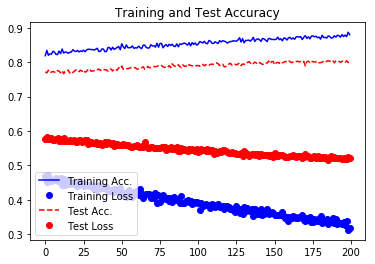

In [16]:
plot_training_history(history)

## Evaluate the model on few examples and save the confussion matrix

Test-set classification accuracy: 80.15%


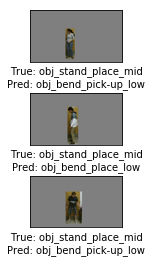

Confusion matrix:
[[ 50   1   0  15  23  13   0   2   0   0   0]
 [  0  22   0   0   0   4   0   1   3   1   0]
 [  0   0  13   0   0   0   0   0   0   0   0]
 [  8   0   0  48   6   0   0   1   0   0   0]
 [ 15   0   0   8  79   6   0   2   0   1   0]
 [  1   3   0   0   0 364   0  46   8   1   2]
 [  0   0   0   0   0   1  60   0   9   4   0]
 [  2   2   0   2   1  63   1 352   2   1   1]
 [  0   1   0   0   0   9   1   0 125   1   0]
 [  0   1   0   0   0   4   3   5   7  24   0]
 [  0   1   0   0   0   0   0   0   1   0  50]]
(0) obj_stand_place_mid
(1) obj_bend_place_low
(2) obj_stand_place_top
(3) obj_stand_reach_top
(4) none_stand_none_none
(5) obj_bend_pick-up_low
(6) obj_walk_hold_none
(7) none_bend_none_none
(8) obj_stand_pick-up_mid
(9) none_walk_none_none
(10) obj_stand_pick-up_top


In [17]:

result = new_model.evaluate_generator(generator_test, steps=steps_test)

print("Test-set classification accuracy: {0:.2%}".format(result[1]))

example_errors()

## Extracting the features

In [ ]:

with open("Amazon_VGG16model_fineTuned45_UW_500_300.yaml", 'r') as stream:
    model = yaml.load(stream)

In [ ]:
for i in range(5):
    print(i,new_model.layers[i].name)
# feature_extractor = Model(inputs=new_model.input, outputs=new_model.get_layer('flatten_2').output)
feature_extractor = Model(inputs=new_model.input, outputs=new_model.layers[2].output)

### Gets the weight of a specific layer

image_path='./Data/TUM_dataset/Training_frames/train/setting-a-table_open_drawer_low-risk_medium-risk/760_setting-a-table_open_drawer_low-risk_medium-risk_0.jpg'
# Load the first 9 images.
# Load and resize the image using PIL.
img = PIL.Image.open(image_path)
img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

# Plot the image.
# plt.imshow(img_resized)
# plt.show()

# Convert the PIL image to a numpy-array with the proper shape.
img_array = np.expand_dims(np.array(img_resized), axis=0)
# print(np.shape(img_array))

# generate feature [4096]
features = feature_extractor.predict(img_array)
features=np.squeeze(features)
print(features)

# layer_output = get_3rd_layer_output([img_array[0]])

In [ ]:
# later...
# C:\Users\SMARTS_Station\Desktop\Feature_extraction\Data\TUM_dataset\Saved models_TUM
# load YAML and create model
yaml_file = open('./Data/TUM_dataset/Saved_models_TUM/Amazon_VGG16model_fineTuned45_UW_300_300.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("./Data/TUM_dataset/Saved_models_TUM/Amazon_VGG16model_fineTuned45_UW_300_300.h5")
print("Loaded model from disk")
#  
# evaluate loaded model on test data
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']


## we need to compile the model for the changes to take effect.
loaded_model.compile(loss=loss,optimizer=optimizer, metrics=metrics)

print('Model summary:')
print(loaded_model.summary())
# loaded_model.compile(loss='categorical_crossentropy', optimizer='ADAMS', metrics=['accuracy'])
result = loaded_model.evaluate_generator(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
def ExtractFeatures_TUM(model_=loaded_model, frames_folder_path='./data/TUM_dataset/Frames/'):
    
#     feature_extractor = Model(inputs=model_.input, outputs=model_.get_layer('dense').output)
    feature_extractor = Model(inputs=model_.input, outputs=model_.layers[2].output) #first fc layer
    saving_path = './data/TUM_dataset/Extracted_Features/'
    if not os.path.isdir(saving_path):
                os.makedirs(saving_path)
            
    for i, folder in enumerate(os.listdir(frames_folder_path)):
        print('video',folder)
        frame_path = os.path.join(frames_folder_path,folder) #this is the frame path
        feature_vector = np.zeros([1024,len(os.listdir(frame_path))])
        FFF=[];
        for j, frame_ in enumerate(sorted(os.listdir(frame_path))):
            FFF.append(frame_[:-4])
        FFF = sorted(FFF, key=int)
#         print(FFF)
        for j, frame_ in enumerate(FFF):
#             print('frame',frame_)
            
            image_path = os.path.join(frame_path,frame_+'.jpg')
            # Load and resize the image using PIL.
            img = PIL.Image.open(image_path)
            img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
            # Convert the PIL image to a numpy-array with the proper shape.
            img_array = np.expand_dims(np.array(img_resized), axis=0)

            # generate feature [4096]
            features = feature_extractor.predict(img_array)
            features = np.squeeze(features)
            feature_vector[:,j] = features
            
        print(np.shape(feature_vector.T))
        np.save(saving_path+folder,feature_vector.T)
        np.savetxt(saving_path+folder+'.csv', feature_vector, delimiter=",")

    return

In [ ]:
ExtractFeatures()

In [ ]:
import random
AA= np.arange(1,20)
# print(AA)
# print(BB)
ss=0
while ss<6:
    iin=[];x=0;
    while x<15:
        dd = random.randint(1,19)
        if dd not in iin:
            iin.append(dd)
#             ddd.append(np.where(AA-iin[-1] == 0)[0])
            x+=1

    print(iin)
    print(AA[np.where(np.isin(AA, iin)==False)[0]])
    ss+=1

In [ ]:
def ExtractFeatures(frames_folder_path='./data/TUM_dataset/Frames/'):
    
#     feature_extractor = Model(inputs=new_model.input, outputs=new_model.get_layer('dense').output)
    feature_extractor = Model(inputs=new_model.input, outputs=new_model.layers[2].output) #first fc layer
    saving_path = './Data/TUM_dataset/Extracted_Features/'
    if not os.path.isdir(saving_path):
                os.makedirs(saving_path)
            
    for i, folder in enumerate(os.listdir(frames_folder_path)):
        print('video',folder)
        frame_path = os.path.join(frames_folder_path,folder) #this is the frame path
        feature_vector = np.zeros([1024,len(os.listdir(frame_path))+1])
        print(np.shape(feature_vector))
        
        for j, frame_ in enumerate(os.listdir(frame_path)):
#             print('frame',frame_[:-4])
            
            image_path = os.path.join(frame_path,frame_)
            # Load and resize the image using PIL.
            img = PIL.Image.open(image_path)
            img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
            # Convert the PIL image to a numpy-array with the proper shape.
            img_array = np.expand_dims(np.array(img_resized), axis=0)

            # generate feature [4096]
            features = feature_extractor.predict(img_array)
            features = np.squeeze(features)
            print(frame_[:-4])
            feature_vector[:,int(frame_[:-4])] = features
            
#         print(np.shape(feature_vector))
        np.save(saving_path+folder,feature_vector)
        np.savetxt(saving_path+folder+'.csv', feature_vector, delimiter=",")

    return